# ML Pipeline Example

In [21]:
# Imports

import pandas as pd
import numpy as np
import tqdm
import ezkl
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from pathlib import Path
from typing import Union
import json
from hashlib import md5
from math import ceil
import os

base_folder = Path("ml_pipeline/")
data_folder = base_folder / "data/"
zkml_folder = base_folder / "zkml/"

data_folder.mkdir(parents=True, exist_ok=True)
zkml_folder.mkdir(parents=True, exist_ok=True)


## 1. Read data

In [22]:
df = pd.read_csv(data_folder / "df_layer_zero_to_send_100k.csv")

In [23]:
df.head()

,month_start,User Address,Active Days,Active Months,Active Weeks,Amount of total transactions ($),Days since first activity,Days since last transaction,Interacted TX Contracts,Transactions Count,...,Active Days - past 6 windows,Active Months - past 3 windows,Active Months - past 6 windows,Active Weeks - past 3 windows,Active Weeks - past 6 windows,Trend Transactions - past 3 windows,Trend Transactions - past 6 windows,target,Transaction Points Dollars,Transaction Points Count
0,2023-08-01,0x0000000000003e6b8283d286abdbf9a6efa129d0,1.0,1.0,1.0,0.00,7,7,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,2023-03-01,0x000000000000d34c44564053af35e4fe271d0caa,1.0,1.0,1.0,6892.02,7,7,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1
2,2022-05-01,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,1.0,1.0,1.0,0.00,15,15,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,2023-05-01,0x0000000000163081ad5a1a8bf11955a908c1dbb4,1.0,1.0,1.0,16.35,9,9,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4,2023-07-01,0x0000000000163081ad5a1a8bf11955a908c1dbb4,1.0,1.0,1.0,10.49,70,4,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1


In [24]:
df.describe()

,Active Days,Active Months,Active Weeks,Amount of total transactions ($),Days since first activity,Days since last transaction,Interacted TX Contracts,Transactions Count,Transactions Count - past 3 windows,Transactions Count - past 6 windows,...,Active Days - past 6 windows,Active Months - past 3 windows,Active Months - past 6 windows,Active Weeks - past 3 windows,Active Weeks - past 6 windows,Trend Transactions - past 3 windows,Trend Transactions - past 6 windows,target,Transaction Points Dollars,Transaction Points Count
count,100000.000000,100000.0,100000.000000,1.000000e+05,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,68330.000000,99994.000000,100000.0
mean,2.550460,1.0,1.775160,3.548337e+03,94.341700,18.33103,3.057990,6.07170,2.630473,0.702033,...,0.305357,0.339593,0.097948,0.738333,0.203388,0.316860,0.264013,0.589214,1.091716,1.0
std,2.707683,0.0,1.083678,4.723645e+05,89.046156,9.03676,3.239317,10.26125,5.815379,2.755566,...,1.041798,0.441312,0.264546,1.124521,0.607304,3.929901,3.823330,0.491980,0.680743,0.0
min,1.000000,1.0,1.000000,0.000000e+00,0.000000,0.00000,1.000000,1.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.990000,-0.982857,0.000000,0.000000,1.0
25%,1.000000,1.0,1.000000,1.900000e-01,24.000000,12.00000,1.000000,1.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.142857,0.000000,0.000000,1.000000,1.0
50%,2.000000,1.0,1.000000,1.499000e+01,71.000000,20.00000,2.000000,3.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
75%,3.000000,1.0,2.000000,3.955700e+02,139.000000,26.00000,4.000000,7.00000,3.000000,0.000000,...,0.000000,1.000000,0.000000,1.333333,0.000000,0.000000,0.000000,1.000000,1.000000,1.0
max,31.000000,1.0,6.000000,1.416631e+08,621.000000,31.00000,108.000000,644.00000,327.333333,164.333333,...,21.166667,1.000000,1.000000,5.333333,5.166667,503.000000,335.000000,1.000000,6.000000,1.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   month_start                                        100000 non-null  object 
 1   User Address                                       100000 non-null  object 
 2   Active Days                                        100000 non-null  float64
 3   Active Months                                      100000 non-null  float64
 4   Active Weeks                                       100000 non-null  float64
 5   Amount of total transactions ($)                   100000 non-null  float64
 6   Days since first activity                          100000 non-null  int64  
 7   Days since last transaction                        100000 non-null  int64  
 8   Interacted TX Contracts                            100000 non-null  float64

In [29]:
df_to_ml = df[~df["month_start"].isin(["2023-09-01", "2023-10-01", "2023-11-01"])].fillna(0)
df_to_prod = df[df["month_start"].isin(["2023-10-01"])]

In [30]:
feature_selection = [
    col for col in df_to_ml.columns if df_to_ml[col].dtype in ["int64", "float64"]
    if col not in ["target"]
]

## 2. Data preprocessing

In [31]:
def transform_data(
    data: pd.DataFrame,
    feature_cols: list[str],
    scaler: StandardScaler,
) -> torch.Tensor:
    """
    Transform data to torch tensor and scale features.
    """
    assert all(
        [c in data.columns for c in feature_cols]
    ), f"feature_cols {feature_cols} not in data.columns"

    X = data[feature_cols].values
    X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32)

    assert X.shape[1] == len(feature_cols)

    return X

def preprocess_data(
    data: pd.DataFrame,
    label_col: str,
    grouping_col: str,  # data for GroupKFold, in n_splits groups. Also elements left out for test set
    n_splits: int = 5,
    test_size: float = 0.1,  # Fraction of data to use for test set, outside of all folds
    feature_cols: list[str] = None,  # If None, all columns except label_col are used
    do_feature_scaling: bool = True,  # If True, features are scaled to mean 0 and std 1 with sklearn StandardScaler trained on all but test set
    seed: int = 1534,
) -> tuple[
    torch.Tensor,
    torch.Tensor,
    torch.Tensor,
    torch.Tensor,
    list[tuple[np.ndarray, np.ndarray]],
    Union[tuple[StandardScaler, float, float], tuple[None, None, None]],
    pd.Index,
    pd.Index,
]:
    """
    Scale data and and split into features and labels as torch tensors.
    The split is grouped and the test set is not used for scaling.
    """
    assert test_size > 0 and test_size < 1, "test_size must be between 0 and 1"
    assert n_splits > 1, "n_splits must be greater than 1"
    assert (
        grouping_col in data.columns
    ), f"grouping_col {grouping_col} not in data.columns"
    assert label_col in data.columns, f"label_col {label_col} not in data.columns"
    if feature_cols is not None:
        assert all(
            [c in data.columns for c in feature_cols]
        ), f"feature_cols {feature_cols} not in raw_data.columns"

    rng = np.random.default_rng(seed=seed)

    groups_values = data[grouping_col].value_counts().to_dict()
    groups_unique = list(groups_values.keys())
    groups_unique_randomized: list = rng.permutation(groups_unique).tolist()
    total_elements = sum(groups_values.values())
    test_elements_min = ceil(total_elements * test_size)

    print(f"Total elements: {total_elements}")
    print(f"Test elements min: {test_elements_min}\n")

    i = 0
    test_groups = []
    while sum(groups_values[g] for g in test_groups) < test_elements_min:
        test_groups.append(groups_unique_randomized[i])
        i += 1
    train_groups = [g for g in groups_unique if g not in test_groups]

    print(
        f"Final train elements: {sum(groups_values[g] for g in train_groups)} across {len(train_groups)} groups"
    )
    print(
        f"Final test elements: {sum(groups_values[g] for g in test_groups)} across {len(test_groups)} groups"
    )

    # Train test split
    train_data = data[data[grouping_col].isin(train_groups)]
    train_groups = train_data[grouping_col].values
    train_index_new_order = train_data.index
    train_X = (
        train_data[feature_cols].values
        if feature_cols is not None
        else train_data.drop(columns=[label_col, grouping_col]).values
    )
    train_y = train_data[label_col].values

    test_data = data[data[grouping_col].isin(test_groups)]
    test_index_new_order = test_data.index
    test_X = (
        test_data[feature_cols].values
        if feature_cols is not None
        else test_data.drop(columns=[label_col, grouping_col]).values
    )
    test_y = test_data[label_col].values

    # GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)
    group_kfold_splits = list(group_kfold.split(train_X, train_y, groups=train_groups))

    print("\nElements in each fold:")
    for i, (train_index, test_index) in enumerate(group_kfold_splits):
        # format: Fold i: x train elements (n groups), y test elements (n groups)
        print(
            f"Fold {i}: {len(train_index)} ({len(np.unique(train_groups[train_index]))} groups), {len(test_index)} ({len(np.unique(train_groups[test_index]))} groups)"
        )

    # Feature scaling
    if do_feature_scaling:
        scaler = StandardScaler()
        scaler.fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)

        mean = scaler.mean_
        std = scaler.scale_
    else:
        scaler = None
        mean = None
        std = None

    # Convert to torch tensors
    train_X = torch.tensor(train_X, dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.long).unsqueeze(1)
    test_X = torch.tensor(test_X, dtype=torch.float32)
    test_y = torch.tensor(test_y, dtype=torch.long).unsqueeze(1)

    assert train_X.shape[0] == train_y.shape[0]
    assert test_X.shape[0] == test_y.shape[0]
    assert train_X.shape[1] == test_X.shape[1]
    assert train_X.shape[1] == len(feature_cols) if feature_cols is not None else (
        data.shape[1] - 2
    )
    assert train_y.shape[1] == 1
    assert test_y.shape[1] == 1


    # Hash the group_kfold_splits
    group_kfold_splits_hash = md5(json.dumps(str(group_kfold_splits)).encode()).hexdigest()
    print(f"\nGroupKFold splits hash: {group_kfold_splits_hash}")

    return (train_X, train_y, test_X, test_y, group_kfold_splits, (scaler, mean, std), train_index_new_order, test_index_new_order)

In [32]:
label_name = "target"

In [33]:
(
    train_X, 
    train_y, 
    test_X, 
    test_y, 
    group_kfold_splits, 
    (scaler, mean, std),
    train_index_new_order,
    test_index_new_order,
) = preprocess_data(
    data=df_to_ml,
    label_col=label_name,
    grouping_col="User Address",
    n_splits=5,
    test_size=0.1,
    feature_cols=feature_selection,
    do_feature_scaling=True,
    seed=1534,
)

Total elements: 68330
Test elements min: 6833

Final train elements: 61493 across 23163 groups
Final test elements: 6837 across 2611 groups

Elements in each fold:
Fold 0: 49194 (18530 groups), 12299 (4633 groups)
Fold 1: 49194 (18530 groups), 12299 (4633 groups)
Fold 2: 49194 (18530 groups), 12299 (4633 groups)
Fold 3: 49195 (18531 groups), 12298 (4632 groups)
Fold 4: 49195 (18531 groups), 12298 (4632 groups)

GroupKFold splits hash: fa0191d9a34c6feb9bd552ee6f1214eb


## 3. Model definition & training

In [34]:
class Model(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int = 1,
        n_layers: int = 3,
        is_classification: bool = True,
    ):
        super(Model, self).__init__()
        self.sizes = (input_size, hidden_size, n_layers, output_size)
        self.is_binary_classification = is_classification and output_size == 1
        self.is_multiclass_classification = is_classification and output_size > 1
        self.is_regression = not is_classification

        self.fc_start = nn.Linear(input_size, hidden_size)
        self.fc_hiddens = nn.Sequential(*[nn.Linear(hidden_size, hidden_size) for _ in range(n_layers - 2)])
        self.fc_end = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc_start(x))
        for fc in self.fc_hiddens:
            x = F.relu(fc(x))
        x = self.fc_end(x)
        if self.is_binary_classification:
            x = torch.sigmoid(x)
        elif self.is_multiclass_classification:
            x = F.softmax(x, dim=1)
        return x

In [35]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(24, 40)  # First hidden layer
        self.fc2 = nn.Linear(40, 40) # Second hidden layer
        self.fc3 = nn.Linear(40, 40) # Third hidden layer
        self.output = nn.Linear(40, 1) # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x
        return torch.sigmoid(x)

scale_factor = 2  # Adjust between 0 and 1 based on requirements
hidden_size = int(train_X.shape[1] * scale_factor)
n_layers = min(3, max(1, ceil(train_X.shape[1] ** 0.5)))  # Limiting the number of layers to 1-3

model = Model()

print("Model parameters:")
print(f"Input size:         {model.sizes[0]}")
print(f"Hidden size:        {model.sizes[1]}")
print(f"Number of layers:   {model.sizes[2]}")
print(f"Output size:        {model.sizes[3]}")
print("")
print(f"Is binary classification:     {model.is_binary_classification}")
print(f"Is multiclass classification: {model.is_multiclass_classification}")
print(f"Is regression:                {model.is_regression}")

In [36]:
BATCH_SIZE = 64
SHUFFLE_BATCHES = True
EPOCHS = 30
LEARNING_RATE = 0.03

models = []
train_loss_lists = []
train_accuracy_lists = []
valid_loss_lists = []
valid_accuracy_lists = []

# train in cross validation folds
for fold_idx, (train_idx, validation_idx) in enumerate(group_kfold_splits):
    fold_model = Model()
    optimizer = torch.optim.Adam(fold_model.parameters(), lr=LEARNING_RATE)
    #criterion = nn.MSELoss() # or nn.L1Loss(), nn.SmoothL1Loss()
    criterion = nn.BCEWithLogitsLoss()
    
    print(f"\nFold {fold_idx}")
    # prepare data
    train_x_fold = train_X[train_idx]
    train_y_fold = train_y[train_idx]
    validation_x_fold = train_X[validation_idx]
    validation_y_fold = train_y[validation_idx]

    train_dataset = TensorDataset(train_x_fold, train_y_fold)
    validation_dataset = TensorDataset(validation_x_fold, validation_y_fold)

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_BATCHES
    )
    validation_loader = DataLoader(
        validation_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    # train

    train_loss_list = []
    train_accuracy_list = []

    valid_loss_list = []
    valid_accuracy_list = []

    for epoch in range(EPOCHS):
        fold_model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = fold_model(data)
            target = target.to(torch.float32)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        fold_model.eval()
        with torch.no_grad():
            # calculate training logs
            train_pred = fold_model(train_x_fold)
            train_y_fold = train_y_fold.to(torch.float32)
            train_loss = criterion(train_pred, train_y_fold).item()
            train_loss_list.append(train_loss)

            train_pred = torch.sigmoid(train_pred) > 0.5
            train_accuracy = accuracy_score(train_y_fold, train_pred.cpu().numpy())
            train_accuracy_list.append(train_accuracy)

            # calculate validation logs
            valid_pred = fold_model(validation_x_fold)
            validation_y_fold = validation_y_fold.to(torch.float32)

            valid_loss = criterion(valid_pred, validation_y_fold).item()
            valid_loss_list.append(valid_loss)

            valid_pred = torch.sigmoid(valid_pred) > 0.5
            valid_accuracy = accuracy_score(
                validation_y_fold, valid_pred.cpu().numpy()
            )
            valid_accuracy_list.append(valid_accuracy)

        if epoch % 10 == 0:
            print(
                f"Epoch: {epoch} Train loss: {train_loss:.4f} Validation loss: {valid_loss:.4f}"
            )

    models.append(fold_model)
    train_loss_lists.append(train_loss_list)
    train_accuracy_lists.append(train_accuracy_list)
    valid_loss_lists.append(valid_loss_list)
    valid_accuracy_lists.append(valid_accuracy_list)

    print(f"Fold {fold_idx} done, metrics:")
    print(f"  Train loss: {train_loss:.4f}")
    print(f"  Validation loss: {valid_loss:.4f}")
    print(f"  Train accuracy: {train_accuracy:.4f}")
    print(f"  Validation accuracy: {valid_accuracy:.4f}")


Fold 0
Epoch: 0 Train loss: 0.6443 Validation loss: 0.6442
Epoch: 10 Train loss: 0.6146 Validation loss: 0.6193
Epoch: 20 Train loss: 0.6120 Validation loss: 0.6221
Fold 0 done, metrics:
  Train loss: 0.6137
  Validation loss: 0.6208
  Train accuracy: 0.6537
  Validation accuracy: 0.6454

Fold 1
Epoch: 0 Train loss: 0.6249 Validation loss: 0.6239
Epoch: 10 Train loss: 0.6262 Validation loss: 0.6284
Epoch: 20 Train loss: 0.6111 Validation loss: 0.6138
Fold 1 done, metrics:
  Train loss: 0.6111
  Validation loss: 0.6127
  Train accuracy: 0.6501
  Validation accuracy: 0.6508

Fold 2
Epoch: 0 Train loss: 0.6243 Validation loss: 0.6287
Epoch: 10 Train loss: 0.6148 Validation loss: 0.6201
Epoch: 20 Train loss: 0.6279 Validation loss: 0.6308
Fold 2 done, metrics:
  Train loss: 0.6522
  Validation loss: 0.6584
  Train accuracy: 0.6217
  Validation accuracy: 0.6125

Fold 3
Epoch: 0 Train loss: 0.6193 Validation loss: 0.6162
Epoch: 10 Train loss: 0.6230 Validation loss: 0.6227
Epoch: 20 Train l

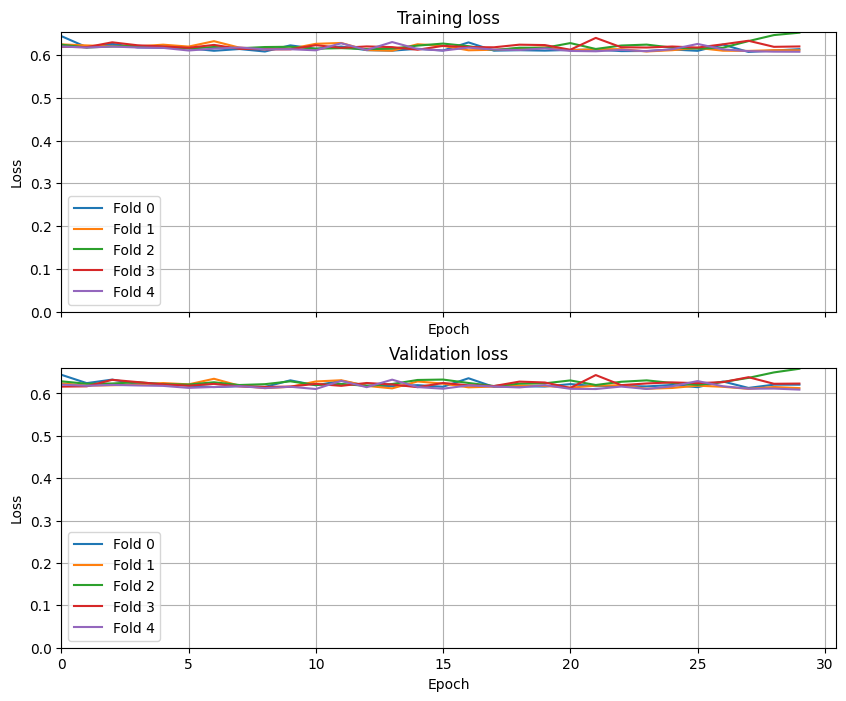

In [37]:
# Plot the loss evolution for all folds

# First the training loss
fig = plt.figure(figsize=(10, 8))
axes: list[Axes] = fig.subplots(2, 1, sharex=True)
ax = axes[0]
for i, train_loss_list in enumerate(train_loss_lists):
    ax.plot(train_loss_list, label=f"Fold {i}")
ax.set_title("Training loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.grid()

# Then the validation loss
ax = axes[1]
for i, valid_loss_list in enumerate(valid_loss_lists):
    ax.plot(valid_loss_list, label=f"Fold {i}")
ax.set_title("Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.grid()
plt.show()


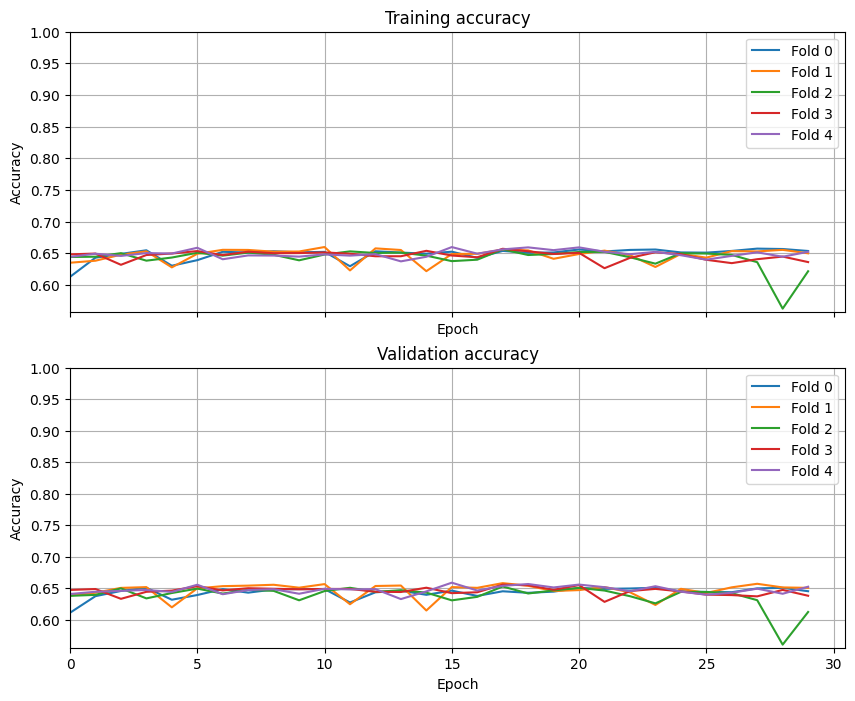

In [38]:
# Now the accuracy evolution for all folds
# Plot the loss evolution for all folds

# First the training loss
fig = plt.figure(figsize=(10, 8))
axes: list[Axes] = fig.subplots(2, 1, sharex=True)
ax = axes[0]
for i, train_accuracy_list in enumerate(train_accuracy_lists):
    ax.plot(train_accuracy_list, label=f"Fold {i}")
ax.set_title("Training accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_ylim(top=1)
ax.set_xlim(left=0)
ax.grid()

# Then the validation loss
ax = axes[1]
for i, valid_accuracy_list in enumerate(valid_accuracy_lists):
    ax.plot(valid_accuracy_list, label=f"Fold {i}")
ax.set_title("Validation accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_ylim(top=1)
ax.set_xlim(left=0)
ax.grid()
plt.show()

## 4. Model evaluation

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import (
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)
from typing import List
import torch


def evaluate_models(
    models: List[torch.nn.Module], test_X: torch.Tensor, test_y: torch.Tensor
) -> None:
    plt.figure(figsize=(6, 6))

    # Plotting Precision-Recall curves for all models
    for i, model in enumerate(models):
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            outputs = torch.sigmoid(model(test_X).squeeze())

        precision, recall, thresholds = precision_recall_curve(test_y, outputs)
        plt.plot(recall, precision, marker=".", label=f"Model {i+1}")

    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    # Confusion matrices
    num_models = len(models)
    fig, axs = plt.subplots(1, num_models, figsize=(6 * num_models, 6))
    if num_models == 1:
        axs = [axs]  # Ensure axs is iterable for a single model

    for i, model in enumerate(models):
        with torch.no_grad():
            outputs = torch.sigmoid(model(test_X).squeeze())
        predictions = (outputs > 0.5).int()
        conf_matrix = confusion_matrix(test_y, predictions)

        ax: Axes = axs[i]
        cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=ax)
        ax.set_title(f"Model {i+1}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        # Annotate each cell with the numeric value
        for j, k in itertools.product(
            range(conf_matrix.shape[0]), range(conf_matrix.shape[1])
        ):
            ax.text(
                k,
                j,
                f"{conf_matrix[j, k]}",
                ha="center",
                va="center",
                color="white" if conf_matrix[j, k] > conf_matrix.max() / 2 else "black",
                size=40,
            )

    plt.tight_layout()
    plt.show()

    # Print classification reports
    for i, model in enumerate(models):
        with torch.no_grad():
            outputs = torch.sigmoid(model(test_X).squeeze())
        predictions = (outputs > 0.5).int()
        conf_matrix = confusion_matrix(test_y, predictions)
        classification_report_model = classification_report(test_y, predictions)
        print(f"Classification Report for Model {i+1}:")
        print(classification_report_model)


# Example usage
# evaluate_models(models, test_X, test_y)

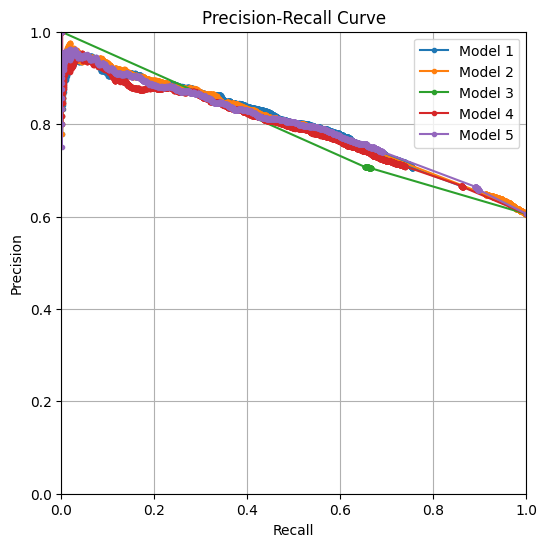

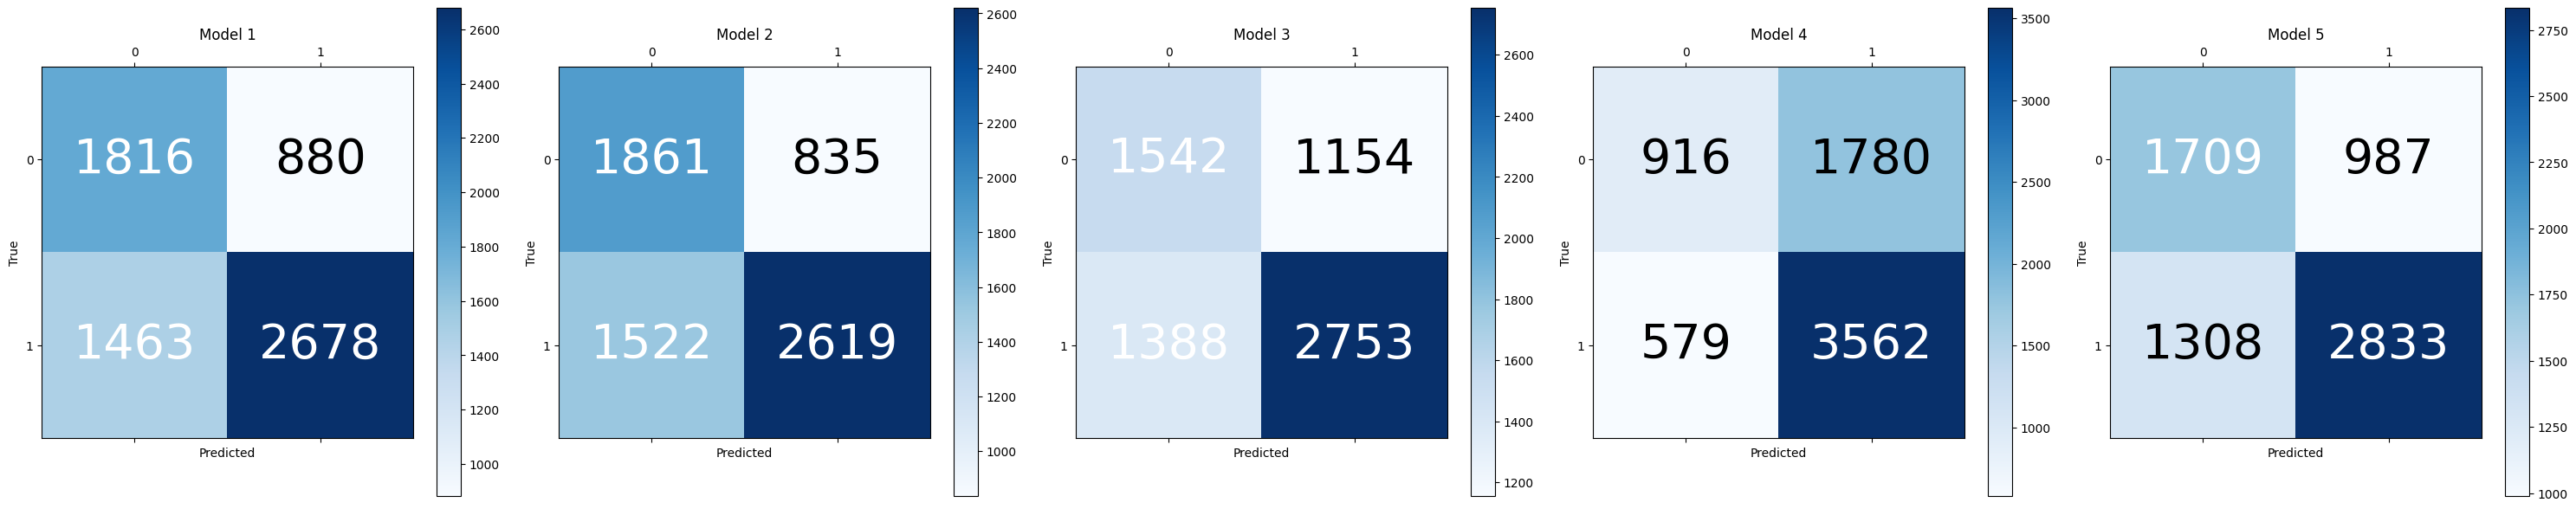

Classification Report for Model 1:
              precision    recall  f1-score   support

           0       0.55      0.67      0.61      2696
           1       0.75      0.65      0.70      4141

    accuracy                           0.66      6837
   macro avg       0.65      0.66      0.65      6837
weighted avg       0.67      0.66      0.66      6837

Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.55      0.69      0.61      2696
           1       0.76      0.63      0.69      4141

    accuracy                           0.66      6837
   macro avg       0.65      0.66      0.65      6837
weighted avg       0.68      0.66      0.66      6837

Classification Report for Model 3:
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      2696
           1       0.70      0.66      0.68      4141

    accuracy                           0.63      6837
   macro avg       0.62

In [40]:
evaluate_models(models, test_X, test_y)

In [41]:
# select one of the models once you are happy with the results
final_model: nn.Module = models[3]

## 5. SHAP

In [42]:
import shap
import torch
import matplotlib.pyplot as plt
from typing import Union, List


class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        logits = self.model(x)
        probabilities = torch.sigmoid(logits)
        return probabilities


def calculate_shap_values(model: nn.Module, X: torch.Tensor):
    # Ensure the model is in evaluation mode
    model.eval()

    # Wrap the model with a GradientExplainer
    explainer = shap.GradientExplainer(model, X)

    # Get SHAP values for the specific input sample
    shap_values = explainer.shap_values(X)

    return shap_values


def display_beeswarm(
    model: nn.Module,
    data_X: torch.Tensor,
    feature_names: Union[List[str], None] = None,
    shap_values: Union[np.ndarray, None] = None,
):
    if shap_values is None:
        shap_values = calculate_shap_values(model, data_X)

    if not feature_names:
        feature_names = [f"Feature_{i}" for i in range(data_X.shape[1])]

    # Plotting the beeswarm plot
    shap.summary_plot(
        shap_values,
        features=data_X,
        feature_names=feature_names,
    )
    plt.show()

def display_waterfall(
    shap_values: np.ndarray,
    model: nn.Module,
    X: torch.Tensor,
    idx: int,
    feature_names: Union[List[str], None] = None,
    max_display: int = 10,
):
    # Calculate the expected value (mean model output on train data)
    with torch.no_grad():
        expected_value = model(X).mean().item()

    if not feature_names:
        feature_names = [f"Feature_{i}" for i in range(input_sample.shape[1])]

    input_sample = X[idx].unsqueeze(0)

    # Prepare the SHAP explanation object
    shap_explanation = shap.Explanation(
        values=shap_values[0].squeeze(),  # Adjust based on your output shape
        base_values=expected_value,
        data=input_sample.numpy().squeeze(),  # Adjust as needed
        feature_names=feature_names,
    )

    # Create the waterfall plot
    shap.waterfall_plot(
        shap_explanation,
        max_display=max_display,
        show=False,
    )
    plt.show()



In [43]:
all_X = torch.cat([train_X, test_X])[:1000]
shap_values = calculate_shap_values(final_model, all_X)

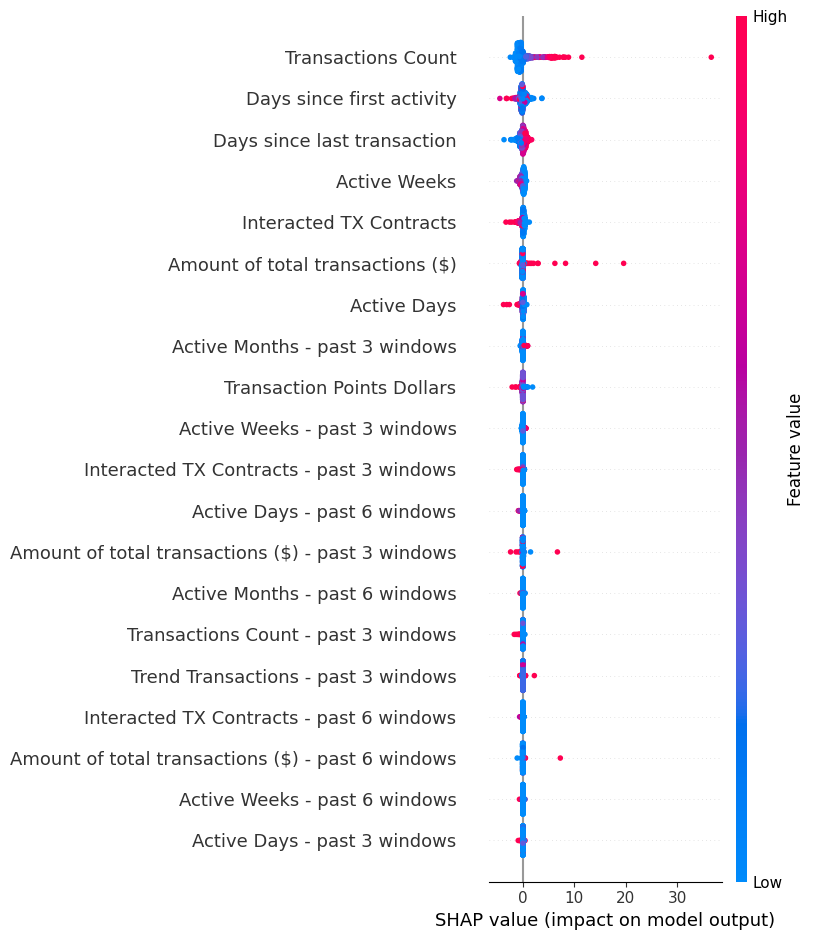

In [44]:
display_beeswarm(ModelWrapper(final_model), all_X, feature_selection, shap_values)

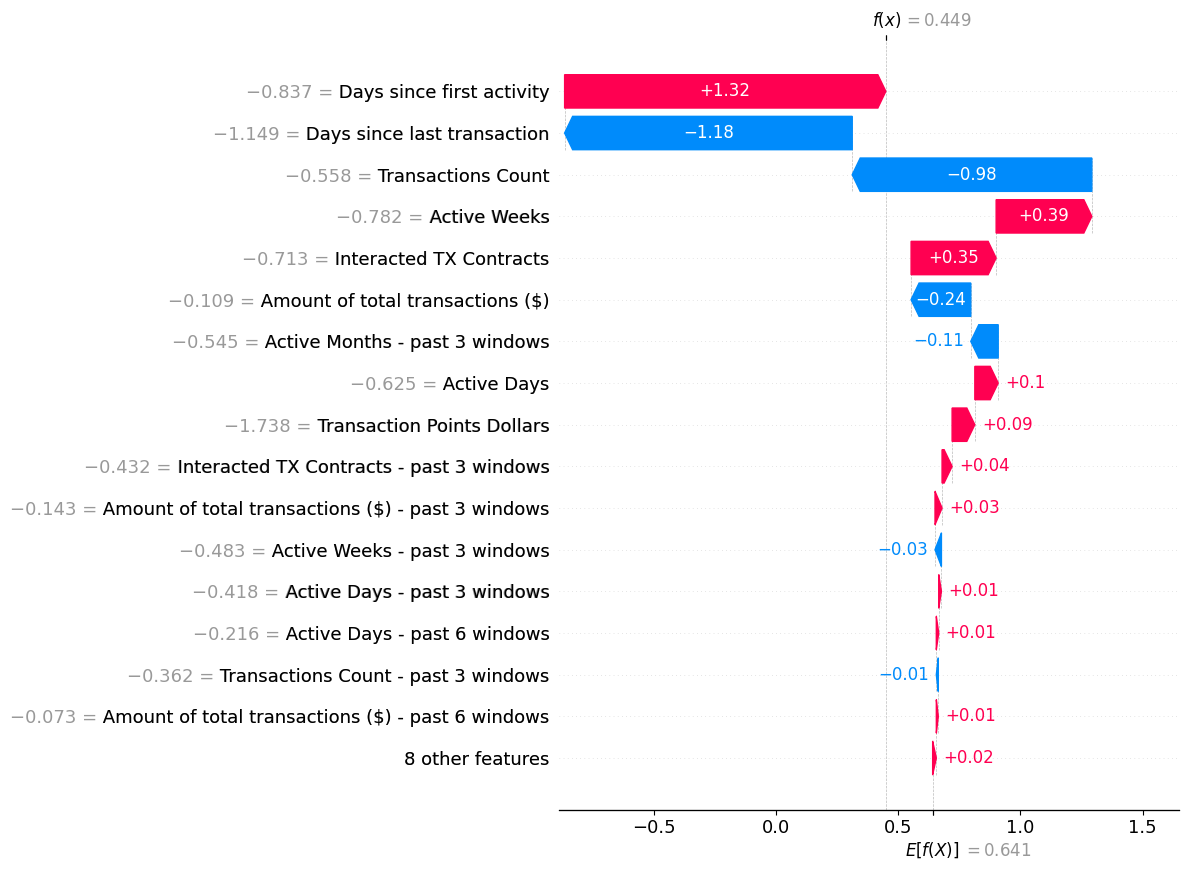

In [45]:
display_waterfall(
    shap_values,
    ModelWrapper(final_model),
    all_X,
    0,
    feature_selection,
    max_display=17,
)

## 6. ZKML model serialization

In [46]:
model_path = zkml_folder / "network.onnx"
compiled_model_path = zkml_folder / "network.ezkl"
pk_path = zkml_folder / "key.pk"
vk_path = zkml_folder / "key.vk"
settings_path = zkml_folder / "settings.json"
srs_path = zkml_folder / "kzg.srs"
witness_path = zkml_folder / "witness.json"
data_path = zkml_folder / "input_data.json"
cal_data_path = zkml_folder / "cal_data.json"
proof_path = zkml_folder / "proof.json"
proof_data_path = zkml_folder / "proof_data.json"

In [47]:
sample_input = test_X[0].reshape(1, -1)

data_array = (sample_input.detach().numpy()).reshape([-1]).tolist()

data = dict(input_data=[data_array])

# Serialize data into file:
with data_path.open("w") as f:
    json.dump(data, f)


# use the test set to calibrate the circuit
cal_data = dict(input_data=test_X.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, "w"))

In [48]:
final_model.eval()

torch.onnx.export(
    final_model,  # model being run
    sample_input,  # model input (or a tuple for multiple inputs)
    model_path,  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=10,  # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=["input"],  # the model's input names
    output_names=["output"],  # the model's output names
    dynamic_axes={
        "input": {0: "batch_size"},  # variable length axes
        "output": {0: "batch_size"},
    },
)

In [49]:
# concat test_X and train_X
all_X = torch.cat((test_X, train_X), 0)

proof_input = all_X
proof_data_array = proof_input.detach().numpy().tolist()
proof_data = dict(input_data=proof_data_array)

with proof_data_path.open("w") as f:
    json.dump(proof_data, f)

In [50]:
py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.output_visibility = "public"
py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
assert res == True, "Failed to generate settings"

res = await ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources")
assert res == True, "Failed to calibrate settings"

In [51]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [52]:
res = ezkl.get_srs(srs_path, settings_path)

In [53]:
res = ezkl.setup(
    compiled_model_path,
    vk_path,
    pk_path,
    srs_path,
)


assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

spawning module 2
spawning module 2


In [54]:
# Generate the Witness for the proof

# now generate the witness file
res = ezkl.gen_witness(proof_data_path, compiled_model_path, witness_path)
assert witness_path.is_file()

In [55]:
# Generate the proof

proof = ezkl.prove(
    witness_path,
    compiled_model_path,
    pk_path,
    proof_path,
    srs_path,
    "single",
)

print(proof)
assert os.path.isfile(proof_path)

spawning module 2


{'instances': [[[4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [0, 0, 0, 0], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [0, 0, 0, 0], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [16912579398983483403, 13419314142665758269, 16965902948054780928, 1463492787413574090], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [0, 0, 0, 0], [16912579398983483403, 13419314142665758269, 16965902948054780928, 1463492787413574090], [10902020042510041094, 17381486299841078119, 5900175412809962030, 247524

In [56]:
# verify our proof

res = ezkl.verify(
    proof_path,
    settings_path,
    vk_path,
    srs_path,
)

assert res == True
print("verified")

verified


## 7. Generate output for backend

In [57]:
X_to_prod = transform_data(df_to_prod, feature_selection, scaler)

In [58]:
prod_predictions = ModelWrapper(final_model)(X_to_prod).detach().numpy().flatten()

In [59]:
# insert all_predictions into df using the index (concat train_index_new_order and test_index_new_order)

df_final = df_to_prod.copy()
df_final["prediction"] = prod_predictions

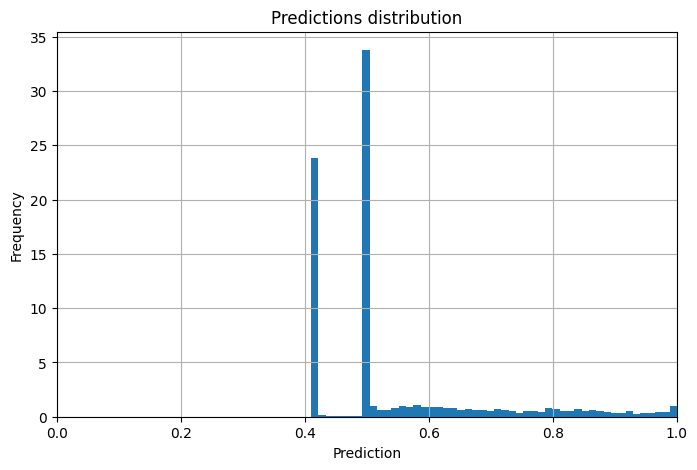

In [60]:
fig, ax = plt.subplots(figsize=(8, 5))
ax: Axes
ax.hist(df_final["prediction"], bins=50, density=True)
ax.set_title("Predictions distribution")
ax.set_xlabel("Prediction")
ax.set_ylabel("Frequency")
ax.grid()
ax.set_xlim(0, 1)

plt.show()

In [61]:
df_final["Transactions Count"]

7         1.0
13        2.0
20        2.0
52        7.0
70        9.0
         ... 
99950     1.0
99953     3.0
99979     1.0
99984     6.0
99992    13.0
Name: Transactions Count, Length: 10762, dtype: float64

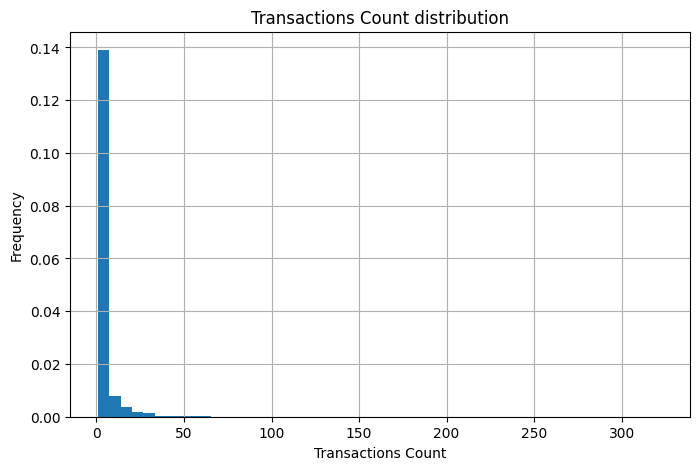

In [62]:
fig, ax = plt.subplots(figsize=(8, 5))
ax: Axes
ax.hist(df_final["Transactions Count"], bins=50, density=True)
ax.set_title("Transactions Count distribution")
ax.set_xlabel("Transactions Count")
ax.set_ylabel("Frequency")
ax.grid()

plt.show()

In [63]:
user_probas = {
    row["User Address"]: float(row["prediction"]) for _, row in df_final.iterrows()
}

In [64]:
from typing import Any


def generate_user_groups(
    groups: list[tuple[str, float, float]], 
    data: pd.DataFrame,
    prediction_col: str,
    value_col: str,
) -> list[dict[str, Any]]:
    groups_data = []
    for label, lower, higher in groups:
        data_group = data[(data[value_col] >= lower) & (data[value_col] < higher)]
        count = len(data_group)
        mean = data_group[prediction_col].mean()
        median = data_group[prediction_col].median()
        pct25 = data_group[prediction_col].quantile(0.25)
        pct75 = data_group[prediction_col].quantile(0.75)
        pct10 = data_group[prediction_col].quantile(0.1)
        pct90 = data_group[prediction_col].quantile(0.9)
        total_value = data_group[value_col].sum()
        mean_value = data_group[value_col].mean()
        median_value = data_group[value_col].median()
        group_data = {
            "label": label,
            "lower": float(lower),
            "higher": float(higher),
            "count": float(count),
            "mean": float(mean),
            "median": float(median),
            "pct25": float(pct25),
            "pct75": float(pct75),
            "pct10": float(pct10),
            "pct90": float(pct90),
            "value_generated": float(total_value),
            "value_generated_mean": float(mean_value),
            "value_generated_median": float(median_value),
        }
        groups_data.append(group_data)

    while groups_data[-1]["count"] == 0:
        groups_data.pop()

    return groups_data


In [65]:
user_groups = generate_user_groups(
    groups = [
        ("1 - 5", 1, 5),
        ("5 - 20", 5, 20),
        ("20 - 50", 20, 50),
        ("50 - 100", 50, 100),
        ("100+", 100, 10000000000),
    ],
    data = df_final,
    prediction_col = "prediction",
    value_col = "Transactions Count",
)

In [66]:
final_data = {
    "user_probas": user_probas,
    "user_groups": user_groups
}

In [67]:
# save final_data to json in the data folder as prod_data.json
with (data_folder / "prod_data.json").open("w") as f:
    json.dump(final_data, f)